Project : Image Classification

Things to submit:
1. PPT
2. Video

**Problem Statement** : Enhancing Handwritten Digit Recognition for Practical Applications

**Background:**

Handwriting recognition plays a crucial role in modern automation systems, enabling seamless digitization of handwritten content for applications such as postal services, banking, and education. Despite the advancements in machine learning, accurately identifying handwritten characters remains a challenge due to variations in writing styles, distortions, and inconsistencies in user inputs.

This project aims to develop a robust image classification model that accurately recognizes handwritten digits using machine learning techniques. Leveraging publicly available datasets, such as the MNIST dataset, we will preprocess and analyze data to extract meaningful features, compare multiple machine learning algorithms, and evaluate their performance using accuracy and computational efficiency metrics.

Our objective is to enhance recognition accuracy while maintaining computational efficiency, making the model practical for real-world deployment. This study will not only provide insights into machine learning-based classification but also serve as a foundation for future advancements in handwritten text recognition technologies.


**LIBRARY & DATASET**

In [1]:
# Install the required packages if you do not have
# pip install seaborn
# pip install scikit-learn
# pip install scikit-image

In [2]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Perceptron  # Simple linear model for RFE
from scipy.stats import uniform, randint

MNIST dataset from Kaggle

The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems.

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [3]:
# Fetching the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y = True)

**DATA PREPROCESSING**

In [4]:
# Convert target labels to integers
y = y.astype(np.uint8)

# Show dataset shape
print(f"Dataset shape: {X.shape}")  # Rows (samples) x Columns (features)

# Display column names
print(f"Column names: {X.shape[1]} pixel features (pixel0 to pixel783)")

# Check for missing values
missing_values = np.sum(pd.DataFrame(X).isnull().sum())
print(f"Total missing values: {missing_values}")

# Basic statistics
df = pd.DataFrame(X)
print("Basic statistics of pixel values:")
print(df.describe())

Dataset shape: (70000, 784)
Column names: 784 pixel features (pixel0 to pixel783)
Total missing values: 0
Basic statistics of pixel values:
        pixel1   pixel2   pixel3  ...  pixel782  pixel783  pixel784
count  70000.0  70000.0  70000.0  ...   70000.0   70000.0   70000.0
mean       0.0      0.0      0.0  ...       0.0       0.0       0.0
std        0.0      0.0      0.0  ...       0.0       0.0       0.0
min        0.0      0.0      0.0  ...       0.0       0.0       0.0
25%        0.0      0.0      0.0  ...       0.0       0.0       0.0
50%        0.0      0.0      0.0  ...       0.0       0.0       0.0
75%        0.0      0.0      0.0  ...       0.0       0.0       0.0
max        0.0      0.0      0.0  ...       0.0       0.0       0.0

[8 rows x 784 columns]


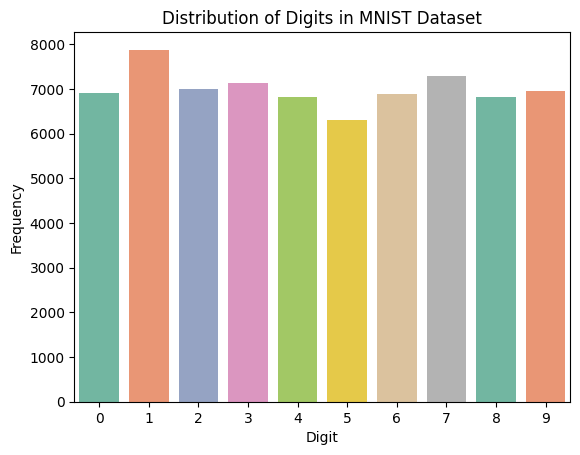

In [5]:
# Display & Visualise class distribution
sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Distribution of Digits in MNIST Dataset")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.show()

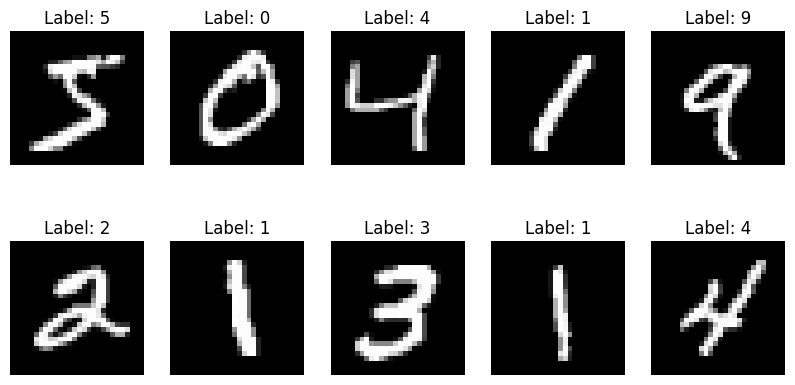

In [6]:
#Display Sample Handwritten Digits

# Ensure X is a NumPy array
X_array = np.array(X)
# Display some example images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_array[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.show()

**DATA PREPARATION**

Standardization Method - k-NN, SVMs
Better for algorithms relying on distance between data point
When calculating Standard Deviation, you use the mean of pixel values, which is different for every image, which results in different SD values

In [5]:
scaler = StandardScaler()
X_prepared = scaler.fit_transform(X)

In [6]:
# Spliting dataset into training (80) & testing (20) sets
# Explain why this split #TODO

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (56000, 784)
Test data shape: (14000, 784)
Training labels shape: (56000,)
Test labels shape: (14000,)


**FEATURE EXTRACTION for the MNIST Dataset**

Feature extraction helps reduce dimensionality, highlight important patterns, and improve model performance. Below are different feature extraction techniques applicable to MNIST:

**1. Raw Pixel Features (Baseline)**

The MNIST dataset consists of 28×28 grayscale images, each represented as 784 pixel intensity values. This raw format is commonly used for training deep learning models, but for traditional machine learning models like Decision Trees, KNN, or SVM, extracting informative features can improve efficiency.

✔ Advantage: Retains full information

✘ Disadvantage: High dimensionality (784 features) leads to slow training for some models

**2. Principal Component Analysis (PCA)**

PCA is a dimensionality reduction technique that extracts the most important features by transforming the data into a lower-dimensional space.

✔ Advantage: Reduces dimensionality while preserving most variance

✘ Disadvantage: Some information is lost

**3. Histogram of Oriented Gradients (HOG)**

HOG extracts gradient and edge direction features, which are more effective than raw pixel intensities.

✔ Advantage: Extracts meaningful texture and shape information

✘ Disadvantage: Can be computationally expensive

**4. Zoning Features (Statistical Features)**

Zoning divides the image into regions and computes statistical properties (mean, variance) for each.

✔ Advantage: Simple and computationally efficient

✘ Disadvantage: May lose fine-grained pixel information

**5. Fourier Transform Features (Frequency Domain)**

Fourier Transform converts images into the frequency domain, capturing shape patterns.

✔ Advantage: Captures global shape information

✘ Disadvantage: Computationally expensive

**6. Combining Features for Improved Performance**

We can combine multiple features into a single feature set.

✔ Advantage: Combines spatial, statistical, and texture-based features

✘ Disadvantage: Higher computation cost

In [9]:
# Reshape into flattened 1D features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Train shape: {X_train_flat.shape}, Test shape: {X_test_flat.shape}")

Train shape: (56000, 784), Test shape: (14000, 784)


In [10]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 50 principal components
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

print(f"Original shape: {X_train_flat.shape}, PCA reduced shape: {X_train_pca.shape}")

Original shape: (56000, 784), PCA reduced shape: (56000, 50)


In [15]:
# pip install scikit-image
from skimage.feature import hog

# Function to compute HOG features for MNIST images
def compute_hog_features(images):
    hog_features = []
    for img in images:
        img = img.reshape(28, 28)  # Reshape to 2D
        features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(features)
    return np.array(hog_features)

# Compute HOG features for training and testing sets
X_train_hog = compute_hog_features(X_train_flat)
X_test_hog = compute_hog_features(X_test_flat)

print(f"HOG feature shape: {X_train_hog.shape}")

HOG feature shape: (56000, 144)


In [16]:
def extract_zoning_features(images, zones=(4, 4)):
    num_zones = zones[0] * zones[1]
    zoning_features = []
    
    for img in images:
        img = img.reshape(28, 28)
        zone_h, zone_w = 28 // zones[0], 28 // zones[1]
        features = []
        
        for i in range(zones[0]):
            for j in range(zones[1]):
                zone = img[i * zone_h:(i + 1) * zone_h, j * zone_w:(j + 1) * zone_w]
                features.append(np.mean(zone))  # Mean intensity
                features.append(np.std(zone))   # Standard deviation
        
        zoning_features.append(features)
    
    return np.array(zoning_features)

# Extract zoning features
X_train_zoning = extract_zoning_features(X_train_flat)
X_test_zoning = extract_zoning_features(X_test_flat)

print(f"Zoning feature shape: {X_train_zoning.shape}")

Zoning feature shape: (56000, 32)


In [17]:
def compute_fourier_features(images):
    fourier_features = []
    for img in images:
        img = img.reshape(28, 28)
        f_transform = np.fft.fft2(img)  # Compute Fourier Transform
        f_features = np.abs(f_transform).flatten()[:100]  # Take first 100 frequencies
        fourier_features.append(f_features)
    
    return np.array(fourier_features)

# Extract Fourier features
X_train_fourier = compute_fourier_features(X_train_flat)
X_test_fourier = compute_fourier_features(X_test_flat)

print(f"Fourier feature shape: {X_train_fourier.shape}")

Fourier feature shape: (56000, 100)


In [18]:
# Concatenate PCA + HOG + Zoning features
from sklearn.preprocessing import StandardScaler

X_train_combination = np.hstack([X_train_pca, X_train_hog, X_train_zoning])
X_test_combination = np.hstack([X_test_pca, X_test_hog, X_test_zoning])

# Normalize feature values
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combination)
X_test_combined = scaler.transform(X_test_combination)

print(f"Final feature shape: {X_train_combined.shape}")

Final feature shape: (56000, 226)


**FEATURE SELECTION**<br>
Recursive Feature Elimination (RFE): Iteratively removes less important features while training a model.

In [19]:
feature_sets = {
    "PCA": X_train_pca,
    "HOG": X_train_hog,
    "Zoning": X_train_zoning,
    "Fourier": X_train_fourier,
    "Combination": X_train_combined
}

# Use Perceptron (a simple linear classifier) for RFE
simple_model = Perceptron(max_iter=1000, tol=1e-3)

# Define number of features to select
num_features_to_select = 50

# Store RFE results
rfe_results = {}

for feature_name, X_feat in feature_sets.items():
    print(f"Applying RFE for {feature_name}...")

    # Reduce dataset size for speed
    X_train_feat, _, y_train_feat, _ = train_test_split(X_feat, y_train, train_size=500, random_state=42)

    # Apply RFE
    selector = RFE(simple_model, n_features_to_select=min(num_features_to_select, X_train_feat.shape[1]), step=10)
    selector.fit(X_train_feat, y_train_feat)

    # Store results
    rfe_results[feature_name] = {
        "Selected Features": np.sum(selector.support_),
        "Feature Mask": selector.support_
    }

# Convert results to DataFrame for easy visualization
df_rfe_results = pd.DataFrame({
    feature: {"Selected Features": data["Selected Features"]}
    for feature, data in rfe_results.items()
}).T

# Display the RFE results
print("\nRFE Feature Selection Results:")
print(df_rfe_results)

Applying RFE for PCA...
Applying RFE for HOG...
Applying RFE for Zoning...
Applying RFE for Fourier...
Applying RFE for Combination...

RFE Feature Selection Results:
             Selected Features
PCA                         50
HOG                         50
Zoning                      32
Fourier                     50
Combination                 50


**Best Feature Set for Each Algorithm**
SVM
✅ Use PCA or HOG
* SVM performs better in lower dimensions.
* PCA removes redundancy, reducing unnecessary data.
* HOG captures edge structures, helping classification.

Random Forest
✅ Use Combination (PCA + HOG + Zoning)
* Handles high-dimensional data well.
* Combination features retain informative patterns.

KNN
✅ Use Zoning or HOG
* KNN relies on distance-based comparisons.
* Zoning and HOG reduce dimensions while keeping useful features.

Decision Tree
✅ Use Combination (PCA + HOG + Zoning)
* Works well with full feature sets.
* Combination features balance feature selection and model interpretability.

Logistic Regression
✅ Use PCA
* Performs best in lower-dimensional space.
* PCA removes noise and keeps important variance.

**ALGORITHMS** (Raw Pixel)

Algo 1 : SVM Support Vector Machine (Bernice Goo)

In [7]:
import time
from sklearn.svm import SVC


# Convert to numpy arrays to ensure consistency
X_train_np = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else np.array(X_train)
X_test_np = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else np.array(X_test)
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

# Train the SVM model with default parameters
print("Training SVM with default parameters...")
svm = SVC(random_state=42)

# Start time for training
start_time = time.time()
svm.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = svm.predict(X_test_np)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
conf_matrix = confusion_matrix(y_test_np, y_pred)
classification_rep = classification_report(y_test_np, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(svm.support_vectors_)

# Print evaluation metrics
print("\nBasic SVM Model Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Number of Support Vectors: {model_complexity}")


Training SVM with default parameters...

Basic SVM Model Evaluation:
Accuracy: 96.31%
Precision: 96.34%
Recall: 96.31%
F1-score: 96.32%
Training Time: 795.3027 seconds
Prediction Time: 393.2164 seconds
Number of Support Vectors: 14794


Algo 2 : Random Forest (Bernice Chng)

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define hyperparameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Allow deep trees
    'min_samples_split': [2, 5, 10],  # Control overfitting
    'min_samples_leaf': [1, 2, 4],  # Prevent small leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Limit number of features per split
    'bootstrap': [True, False]  # Use bootstrap sampling
}

# Take a subset for initial testing due to computational constraints
n_samples = 5000  # Adjust based on computational resources
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for faster hyperparameter tuning
print("Finding best hyperparameters using RandomizedSearchCV for Random Forest...")
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start hyperparameter tuning
start_time = time.time()
random_search_rf.fit(X_train_small, y_train_small)
grid_search_time_rf = time.time() - start_time

# Best hyperparameters
best_params_rf = random_search_rf.best_params_
print(f"Best Parameters for RF: {best_params_rf}")

# Train the best Random Forest model on the full dataset
best_rf = RandomForestClassifier(
    **best_params_rf, random_state=42, n_jobs=-1
)

print("Training the best Random Forest model on full dataset...")
start_time = time.time()
best_rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred_rf = best_rf.predict(X_test)
prediction_time_rf = time.time() - start_time

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Extract precision, recall, and F1-score (weighted average)
precision_rf = classification_rep_rf["weighted avg"]["precision"]
recall_rf = classification_rep_rf["weighted avg"]["recall"]
f1_rf = classification_rep_rf["weighted avg"]["f1-score"]

# Model complexity - Number of trees and max depth
num_trees_rf = best_rf.n_estimators
max_depth_rf = best_rf.max_depth

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf * 100:.2f}%")
print(f"Recall: {recall_rf * 100:.2f}%")
print(f"F1-score: {f1_rf * 100:.2f}%")
print(f"Training Time: {training_time_rf:.4f} seconds")
print(f"Prediction Time: {prediction_time_rf:.4f} seconds")
print(f"Model Complexity: {num_trees_rf} trees, Max Depth: {max_depth_rf}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Feature Importance Analysis
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 most important features (pixels)
plt.figure(figsize=(10, 5))
plt.title("Top 20 Important Pixels in MNIST Classification")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xlabel("Feature Index (Pixel)")
plt.ylabel("Importance Score")
plt.show()

# Feature importance heatmap
importance_grid = importances.reshape(28, 28)  # Reshape into 28x28 for MNIST
plt.figure(figsize=(8, 6))
sns.heatmap(importance_grid, cmap="coolwarm", annot=False)
plt.title("Feature Importance Heatmap (RF)")
plt.show()

# Compare Training Time vs Accuracy
models = ['Random Forest']
accuracies = [accuracy_rf]
times = [training_time_rf]

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue'])
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy")

# Training time plot
plt.subplot(1, 2, 2)
plt.bar(models, times, color=['blue'])
plt.ylabel("Training Time (s)")
plt.title("Random Forest Training Time")

plt.tight_layout()
plt.show()

# Additional visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, hue=y_test, palette="Set3", legend=False)
plt.title("Actual Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_rf, hue=y_pred_rf, palette="Set3", legend=False)
plt.title("Predicted Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


Algo 3: K-Nearest Neighbors (KNN) (Carine)

In [ ]:
# Initialize KNN model
knn_model = KNeighborsClassifier()

# Measure training time
start_time = time.time()
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred = knn_model.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Model complexity (Number of Neighbors)
model_complexity = knn_model.n_neighbors

# Print evaluation metrics
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

KNN Model Accuracy: 94.61%
Precision: 94.64%
Recall: 94.61%
F1-score: 94.60%
Training Time: 0.0469 seconds
Prediction Time: 5.7853 seconds
Model Complexity (Number of Neighbors): 5


Algo 4 : Logistic Regression (Andrea)

In [26]:
# Initialize Logistic Regression model
lr = LogisticRegression()

# Start time for training
start_time = time.time()
lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred_lr = lr.predict(X_test)
prediction_time_lr = time.time() - start_time

# Extract accuracy, precision, recall, and F1-score (weighted average)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Model complexity - Regularization Strength(C) 
# Smaller C = simpler, larger C = complex.
model_complexity = lr.C

# Print evaluation metrics
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Precision: {precision_lr * 100:.2f}%")
print(f"Recall: {recall_lr * 100:.2f}%")
print(f"F1-score: {f1_lr * 100:.2f}%")
print(f"Training Time: {training_time_lr:.4f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")
print(f"Model Complexity (Regularization Strength - C):  {model_complexity}")



Logistic Regression Model Evaluation:
Accuracy: 91.62%
Precision: 91.60%
Recall: 91.62%
F1-score: 91.60%
Training Time: 15.3985 seconds
Prediction Time: 0.0290 seconds
Model Complexity (Regularization Strength - C):  1.0


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Algo 5 : Decision Trees (Yin Er)

In [ ]:
# Step 1: Train the Decision Tree Model
# Initialize Decision Tree classifier with default parameters
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 2: Compute Accuracy
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Step 3: Display Classification Report
# Display classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 4: Display Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


Your Decision Tree Classifier achieved 86.96% accuracy, which is decent but can be improved with hyperparameter tuning.

Key Observations from Your Results
Classification Report:

The precision and recall values are relatively high, meaning the model performs well across different digit classes.
Some numbers (e.g., digit 8) have slightly lower accuracy compared to others, which means the classifier struggles more with these digits.
Confusion Matrix:

Most predictions are along the diagonal, indicating correct classifications.
However, there are some misclassifications (e.g., digit 4 is often confused with 9, digit 3 with 5).
Reducing overfitting and improving decision boundaries can help.

In [ ]:
# Hyperparameter Tuning for Decision Tree

from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the optimized model
y_pred_optimized = best_clf.predict(X_test)

# Calculate accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized:.4f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_optimized))

# Confusion matrix visualization
cm_opt = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8,6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.show()


Decision Tree accuracy improved from 86.96% to 88.09% after hyperparameter tuning! 

Key Improvements
Best Parameters Found:

criterion: entropy (performs better for information gain)
max_depth: 20 (prevents overfitting)
min_samples_leaf: 4 (ensures better generalization)
min_samples_split: 5 (balances model complexity)
Improved Classification Report:

Precision, recall, and F1-score improved slightly across most digits.
Digit misclassification reduced, making the model more reliable.
Better Confusion Matrix:

Misclassifications decreased, meaning fewer errors in recognizing digits.
Some confusion still exists (e.g., 8 and 9 misclassifications), but overall performance improved.

**ALGORITHMS** (Raw Pixels with Randomize Hyperparameter Tuning)

Algorithm 1: Support Vector Machine (Bernice Goo)

Finding hyperparameters using Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': np.float64(1.976218934028007), 'degree': 2, 'gamma': np.float64(0.03752528339573976), 'kernel': 'poly'}
Training the best SVM model on full dataset...

SVM Model with Randomized Search Evaluation:
Accuracy: 97.56%
Precision: 97.56%
Recall: 97.56%
F1-score: 97.56%
Randomized Search Time: 87.0869 seconds
Training Time: 508.4240 seconds
Prediction Time: 338.6889 seconds
Model Complexity (Number of Support Vectors): 12323
Best Parameters: {'C': np.float64(1.976218934028007), 'degree': 2, 'gamma': np.float64(0.03752528339573976), 'kernel': 'poly'}


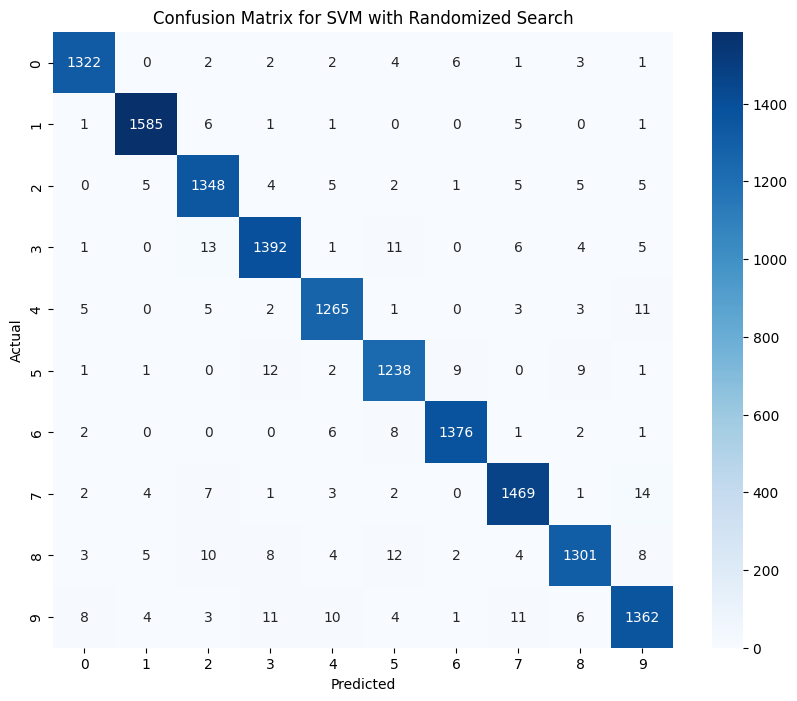

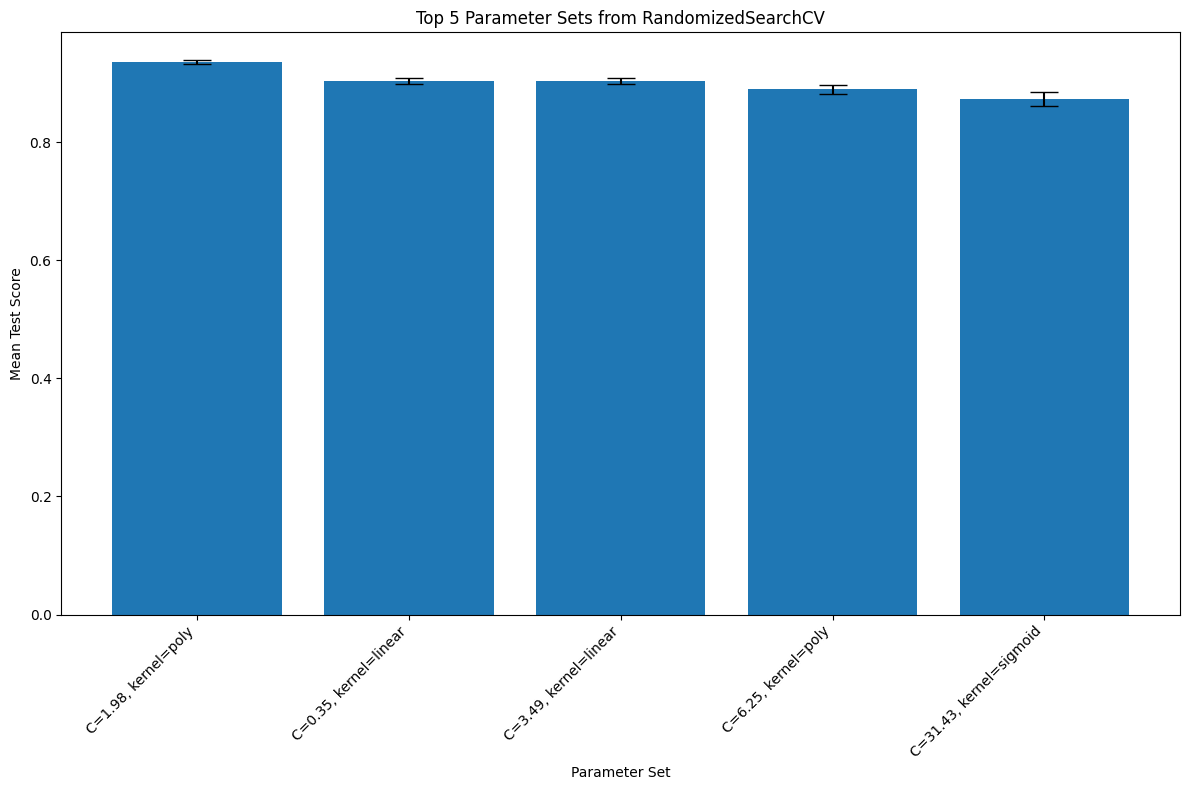

In [8]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Define broader parameter space for randomized search
param_distributions = {
    'C': loguniform(0.1, 100),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': loguniform(0.001, 1),
    'degree': [2, 3, 4, 5]  # for poly kernel
}

# Take a subset for randomized search due to computational constraints
n_samples = 5000  # Adjust based on your computational resources
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

# Initialize SVM model
svm = SVC(random_state=42)

# Use RandomizedSearchCV to find good hyperparameters
print("Finding hyperparameters using Randomized Search...")
random_search = RandomizedSearchCV(
    svm, 
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
# Start time for training randomized search
start_time = time.time()
random_search.fit(X_train_small, y_train_small)
random_search_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best SVM model on the full dataset
best_svm = SVC(**best_params, random_state=42)

# Start time for training
print("Training the best SVM model on full dataset...")
start_time = time.time()
best_svm.fit(X_train, y_train)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = best_svm.predict(X_test)
prediction_time = time.time() - start_time
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(best_svm.support_vectors_)

# Print evaluation metrics
print("\nSVM Model with Randomized Search Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Randomized Search Time: {random_search_time:.4f} seconds")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")
print(f"Best Parameters: {best_params}")

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM with Randomized Search")
plt.show()

# Visualize top performers from randomized search
results = pd.DataFrame(random_search.cv_results_)
top_results = results.sort_values(by='rank_test_score').head(5)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_results)), top_results['mean_test_score'], 
        yerr=top_results['std_test_score'], capsize=10)
plt.xticks(range(len(top_results)), 
           [f"C={p['C']:.2f}, kernel={p['kernel']}" for p in top_results['params']], 
           rotation=45, ha='right')
plt.xlabel('Parameter Set')
plt.ylabel('Mean Test Score')
plt.title('Top 5 Parameter Sets from RandomizedSearchCV')
plt.tight_layout()
plt.show()

Algorithm 2: Random Forest (Bernice Chng)

Algorithm 3: K-Nearest Neighbour (KNN) (Carine)

Best Parameters: {'n_neighbors': np.int64(3)}
Best Cross-Validation Accuracy: 94.32%
KNN Model Accuracy: 94.66%
Precision: 94.68%
Recall: 94.66%
F1-score: 94.65%
Training Time: 157.8692 seconds
Prediction Time: 6.0370 seconds
Model Complexity (Number of Neighbors): 3

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1343
           1       0.95      0.99      0.97      1600
           2       0.95      0.94      0.94      1380
           3       0.93      0.95      0.94      1433
           4       0.95      0.94      0.94      1295
           5       0.95      0.94      0.95      1273
           6       0.97      0.97      0.97      1396
           7       0.94      0.93      0.93      1503
           8       0.97      0.90      0.93      1357
           9       0.90      0.92      0.91      1420

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     1

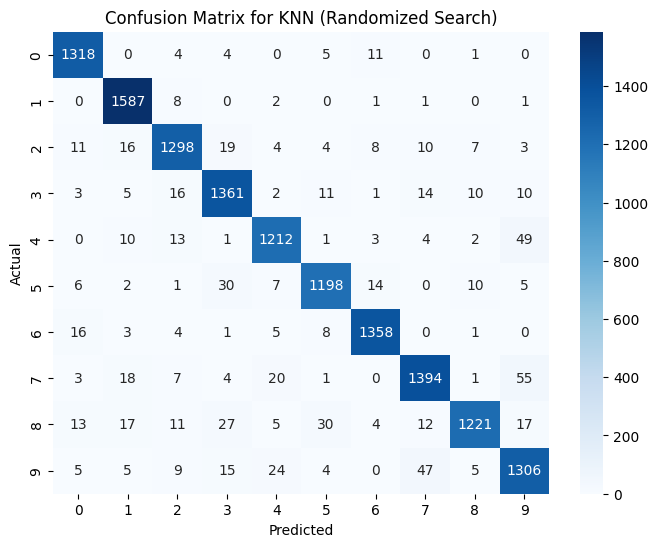

In [27]:
# Define the hyperparameter search space for KNN
param_dist = {'n_neighbors': np.arange(1, 50, 2)}  # Wider range for better tuning

# Initialize KNN model
knn = KNeighborsClassifier()

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)

# Start time for training
start_time = time.time()
random_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score * 100:.2f}%")

# Train the best KNN model
best_knn = random_search.best_estimator_

# Start time for prediction
start_time = time.time()
y_pred = best_knn.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score (weighted)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = best_params["n_neighbors"]

# Print evaluation metrics
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN (Randomized Search)")
plt.show()

Algorithm 4: Logistic Regression (Andrea)

Finding best hyperparameters using RandomizedSearchCV for Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for Logistic Regression: {'C': np.float64(5.925145688620425), 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 918, 'penalty': 'l2', 'solver': 'sag', 'tol': np.float64(0.0017152412368729153)}
Best Cross-Validation Accuracy: 91.98%

Random Forest Model Evaluation:
Accuracy: 92.11%
Precision: 92.09%
Recall: 92.11%
F1-score: 92.09%
Training Time: 357.0874 seconds
Prediction Time: 0.0530 seconds
Model Complexity (Regularization Strength - C):  5.925145688620425

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1343
           1       0.93      0.97      0.95      1600
           2       0.92      0.90      0.91      1380
           3       0.91      0.89      0.90      1433
           4       0.92      0.93      0.92      1295
        

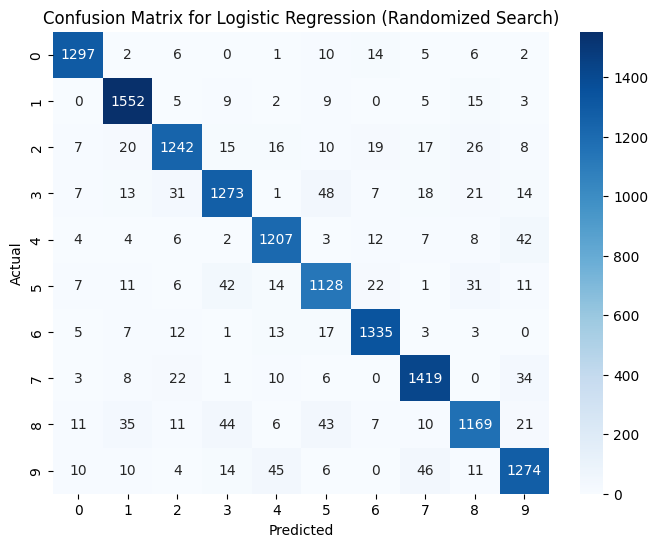

In [38]:
# Define the hyperparameter for Logstic Regression
param_grid_lr = {

    'penalty': ['l2'],  # Regularization types
    'tol': uniform(1e-5, 1e-2),   # Tolerance for optimization convergence
    'C': uniform(0.001, 10),  # Regularization strength (inverse of regularization)
    'fit_intercept': [True, False],  # Whether to include an intercept in the model
    'class_weight': ['balanced', None],  # Weighting classes to handle imbalanced data
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga' ],  # Optimization of algorithms that support multiclass
    'max_iter': randint(100, 1000),  # Maximum number of iterations for optimization

}

# Initialize Logistic Regression model
lr = LogisticRegression()

# Use RandomizedSearchCV for hyperparameter
print("Finding best hyperparameters using RandomizedSearchCV for Logistic Regression...")
random_search_lr = RandomizedSearchCV(
    lr, param_grid_lr, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start time for fiting
start_time = time.time()
random_search_lr.fit(X_train, y_train)
fitting_time_lr = time.time() - start_time


# Best hyperparameters
best_params_lr = random_search_lr.best_params_
best_score_lr = random_search_lr.best_score_
print(f"Best Parameters for Logistic Regression: {best_params_lr}")
print(f"Best Cross-Validation Accuracy: {best_score_lr * 100:.2f}%")

# Train best Logistic Regression model
best_lr = LogisticRegression(
    **best_params_lr, random_state=42, n_jobs=-1
)


# Start time for training
start_time = time.time()
best_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time


# Start time for prediction
start_time = time.time()
y_pred_lr = best_lr.predict(X_test)
prediction_time_lr = time.time() - start_time

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_rep_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Extract precision, recall, and F1-score (weighted average)
precision_lr = classification_rep_lr["weighted avg"]["precision"]
recall_lr = classification_rep_lr["weighted avg"]["recall"]
f1_lr = classification_rep_lr["weighted avg"]["f1-score"]

# Model complexity - Regularization Strength(C) 
# Smaller C = simpler, larger C = complex.
model_complexity = best_params_lr['C']


# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Precision: {precision_lr * 100:.2f}%")
print(f"Recall: {recall_lr * 100:.2f}%")
print(f"F1-score: {f1_lr * 100:.2f}%")
print(f"Training Time: {training_time_lr:.4f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")
print(f"Model Complexity (Regularization Strength - C):  {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression (Randomized Search)")
plt.show()


Algorithm 5: Decision Trees (Yin Er)

**ALGORITHMS** (Selected Best Feature without Hyperparameter Tuning)

Algorithm 1: Support Vector Machine (Bernice Goo)

Selected Feature : PCA


Using PCA features for SVM
Feature dimensions: 50

SVM Model with PCA Evaluation:
Accuracy: 96.94%
Precision: 96.94%
Recall: 96.94%
F1-score: 96.94%
Training Time: 87.5596 seconds
Prediction Time: 43.4344 seconds
Model Complexity (Number of Support Vectors): 11515


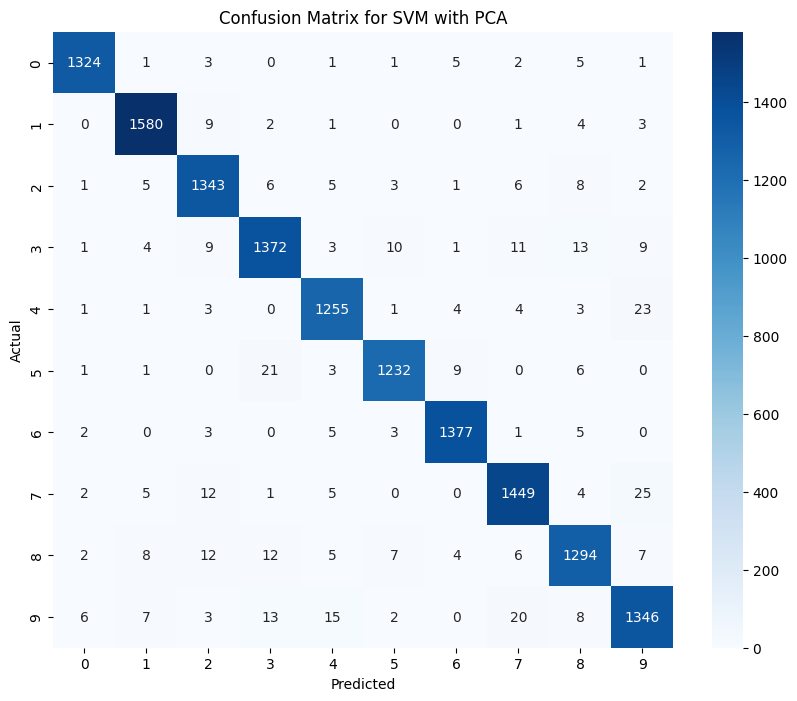

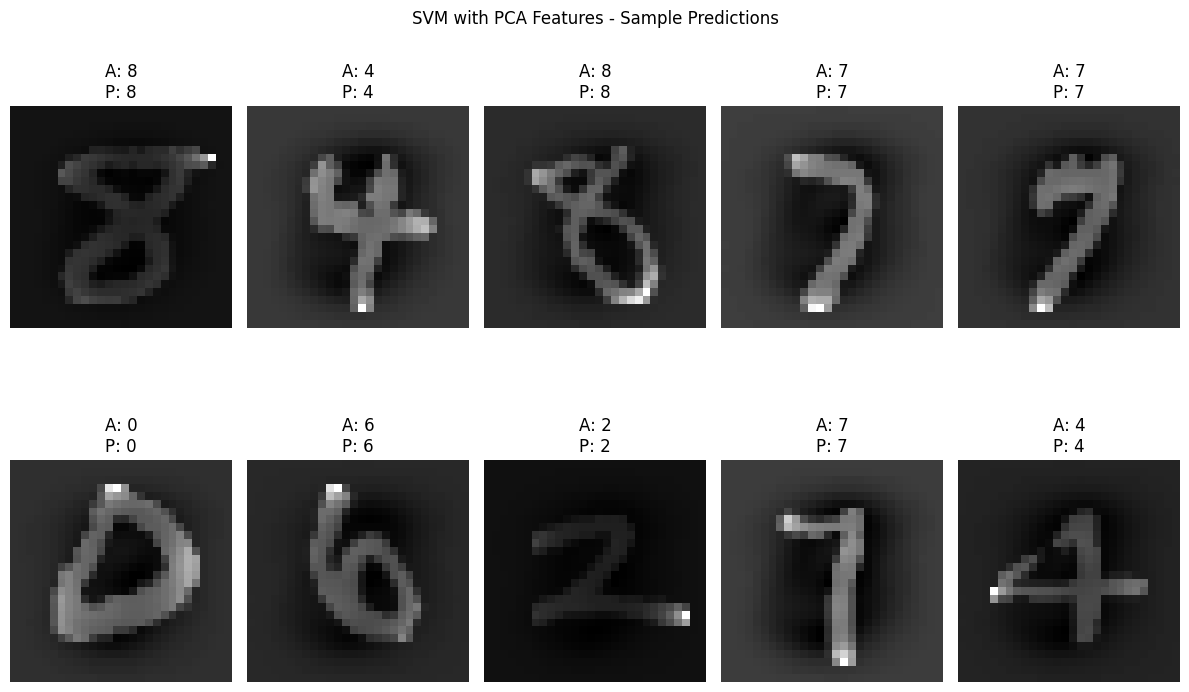

In [13]:
import time
from sklearn.svm import SVC

# Use PCA features
X_train_feature = X_train_pca
X_test_feature = X_test_pca
feature_name = "PCA"

# Convert to numpy arrays if needed
X_train_np = X_train_feature.to_numpy() if hasattr(X_train_feature, 'to_numpy') else np.array(X_train_feature)
X_test_np = X_test_feature.to_numpy() if hasattr(X_test_feature, 'to_numpy') else np.array(X_test_feature)
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

print(f"\nUsing {feature_name} features for SVM")
print(f"Feature dimensions: {X_train_np.shape[1]}")

# Initialize SVM model with default parameters
svm = SVC(random_state=42)

# Start time for training
start_time = time.time()
svm.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = svm.predict(X_test_np)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
conf_matrix = confusion_matrix(y_test_np, y_pred)
classification_rep = classification_report(y_test_np, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(svm.support_vectors_)

# Print evaluation metrics
print(f"\nSVM Model with {feature_name} Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for SVM with {feature_name}")
plt.show()

# Visualize some sample predictions
plt.figure(figsize=(12, 8))
for i in range(10):
    # Get the original image for display
    orig_img = X_test[i].reshape(28, 28) if hasattr(X_test[i], 'reshape') else X_test[i].to_numpy().reshape(28, 28)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"A: {y_test_np[i]}\nP: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle(f"SVM with {feature_name} Features - Sample Predictions", y=0.98)
plt.show()

Selected Feature: HOG


Using HOG features for SVM
Feature dimensions: 144

SVM Model with HOG Evaluation:
Accuracy: 96.56%
Precision: 96.56%
Recall: 96.56%
F1-score: 96.56%
Training Time: 111.2326 seconds
Prediction Time: 52.5621 seconds
Model Complexity (Number of Support Vectors): 11937


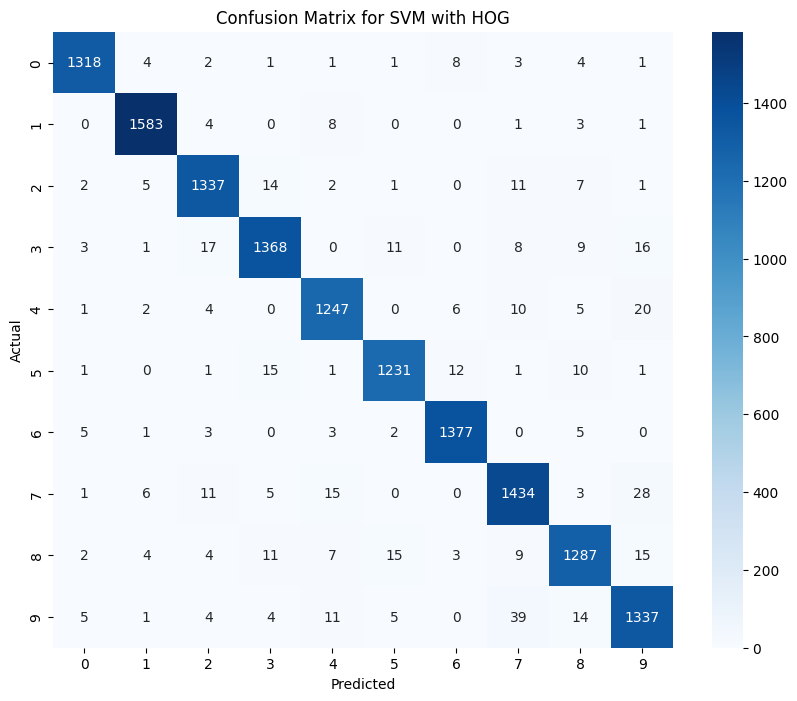

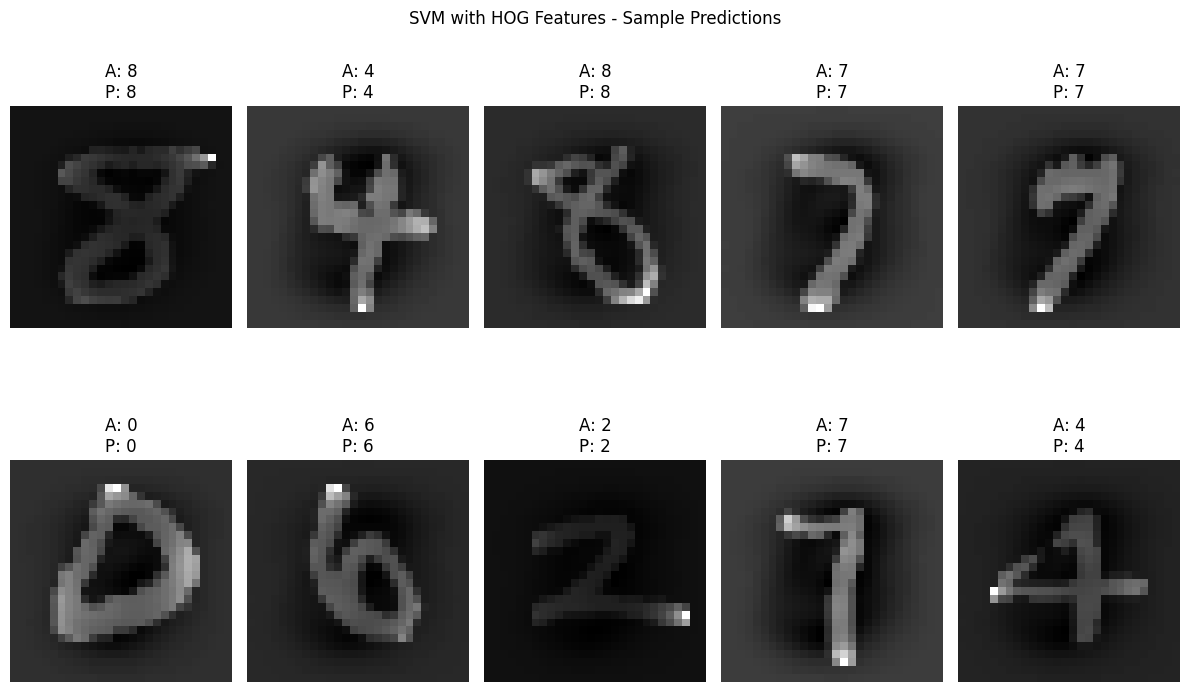

In [14]:
import time
from sklearn.svm import SVC

# Use HOG features
X_train_feature = X_train_hog
X_test_feature = X_test_hog
feature_name = "HOG"

# Convert to numpy arrays if needed
X_train_np = X_train_feature.to_numpy() if hasattr(X_train_feature, 'to_numpy') else np.array(X_train_feature)
X_test_np = X_test_feature.to_numpy() if hasattr(X_test_feature, 'to_numpy') else np.array(X_test_feature)
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

print(f"\nUsing {feature_name} features for SVM")
print(f"Feature dimensions: {X_train_np.shape[1]}")

# Initialize SVM model with default parameters
svm = SVC(random_state=42)

# Start time for training
start_time = time.time()
svm.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = svm.predict(X_test_np)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
conf_matrix = confusion_matrix(y_test_np, y_pred)
classification_rep = classification_report(y_test_np, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(svm.support_vectors_)

# Print evaluation metrics
print(f"\nSVM Model with {feature_name} Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for SVM with {feature_name}")
plt.show()

# Visualize some sample predictions
plt.figure(figsize=(12, 8))
for i in range(10):
    # Get the original image for display
    orig_img = X_test[i].reshape(28, 28) if hasattr(X_test[i], 'reshape') else X_test[i].to_numpy().reshape(28, 28)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"A: {y_test_np[i]}\nP: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle(f"SVM with {feature_name} Features - Sample Predictions", y=0.98)
plt.show()

Algorithm 2: Random Forest (Bernice Chng)

Algorithm 3: K-Nearest Neighbour (KNN) (Carine)

Selected Feature: Zoning

KNN Model Accuracy (Zoning Features): 84.91%
Precision: 84.95%
Recall: 84.91%
F1-score: 84.87%
Training Time: 0.0070 seconds
Prediction Time: 0.6188 seconds
Model Complexity (Number of Neighbors): 5

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1343
           1       0.92      0.97      0.94      1600
           2       0.91      0.86      0.89      1380
           3       0.82      0.83      0.83      1433
           4       0.80      0.81      0.81      1295
           5       0.86      0.79      0.83      1273
           6       0.92      0.94      0.93      1396
           7       0.86      0.82      0.84      1503
           8       0.78      0.73      0.75      1357
           9       0.75      0.80      0.77      1420

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



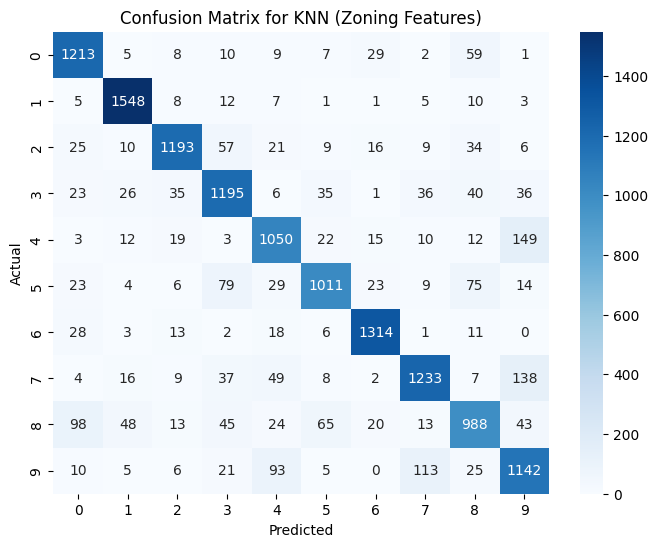

In [31]:
# Initialize and train the KNN model
knn_model = KNeighborsClassifier()

# Measure training time
start_time = time.time()
knn_model.fit(X_train_zoning, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred = knn_model.predict(X_test_zoning)
prediction_time = time.time() - start_time

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score (weighted)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = knn_model.n_neighbors

# Print evaluation metrics
print(f"KNN Model Accuracy (Zoning Features): {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN (Zoning Features)")
plt.show()

Selected Feature: HOG

KNN Model Accuracy (HOG Features): 94.16%
Precision: 94.29%
Recall: 94.16%
F1-score: 94.18%
Training Time: 0.0271 seconds
Prediction Time: 1.4646 seconds
Model Complexity (Number of Neighbors): 5

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1343
           1       0.96      0.98      0.97      1600
           2       0.96      0.93      0.95      1380
           3       0.94      0.93      0.93      1433
           4       0.97      0.90      0.93      1295
           5       0.96      0.94      0.95      1273
           6       0.96      0.98      0.97      1396
           7       0.94      0.92      0.93      1503
           8       0.92      0.91      0.91      1357
           9       0.85      0.94      0.89      1420

    accuracy                           0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



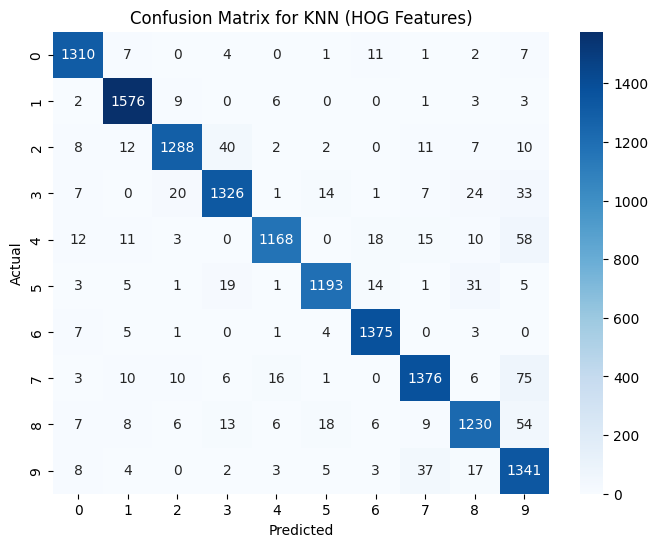

In [34]:
# Initialize and train the KNN model
knn_model = KNeighborsClassifier()

# Measure training time
start_time = time.time()
knn_model.fit(X_train_hog, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred = knn_model.predict(X_test_hog)
prediction_time = time.time() - start_time

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score (weighted)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = knn_model.n_neighbors

# Print evaluation metrics
print(f"KNN Model Accuracy (HOG Features): {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN (HOG Features)")
plt.show()

Algorithm 4: Logistic Regression (Andrea)

Selected Feature: PCA

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Model Evaluation (PCA Features):
Accuracy: 90.55%
Precision: 90.52%
Recall: 90.55%
F1-score: 90.53%
Training Time: 3.3828 seconds
Prediction Time: 0.0020 seconds
Model Complexity (Regularization Strength - C):  1.0

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1343
           1       0.94      0.97      0.96      1600
           2       0.90      0.89      0.89      1380
           3       0.87      0.88      0.87      1433
           4       0.91      0.91      0.91      1295
           5       0.85      0.85      0.85      1273
           6       0.94      0.95      0.95      1396
           7       0.92      0.92      0.92      1503
           8       0.87      0.84      0.85      1357
           9       0.88      0.88      0.88      1420

    accuracy                           0.91     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.91    

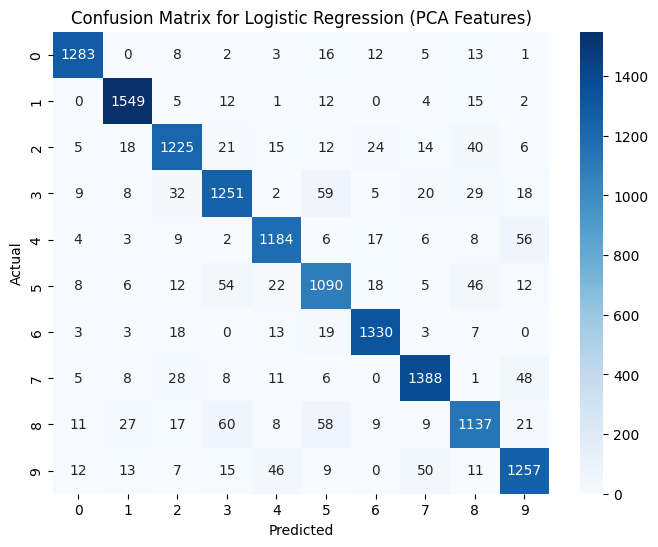

In [36]:
# Initialize Logistic Regression model
lr = LogisticRegression()

# Start time for training
start_time = time.time()
lr.fit(X_train_pca, y_train)
training_time_lr = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred_lr = lr.predict(X_test_pca)
prediction_time_lr = time.time() - start_time

# Extract accuracy, precision, recall, and F1-score (weighted average)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Model complexity - Regularization Strength(C) 
# Smaller C = simpler, larger C = complex.
model_complexity = lr.C

# Print evaluation metrics
print("\nLogistic Regression Model Evaluation (PCA Features):")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Precision: {precision_lr * 100:.2f}%")
print(f"Recall: {recall_lr * 100:.2f}%")
print(f"F1-score: {f1_lr * 100:.2f}%")
print(f"Training Time: {training_time_lr:.4f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")
print(f"Model Complexity (Regularization Strength - C):  {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression (PCA Features)")
plt.show()


Algorithm 5: Decision Trees (Yin Er)

**ALGORITHMS** (Selected Feature + RandomizeSearch Hyperparameter Tuning)

Algorithm 1: Support Vector Machine (SVM) (Bernice Goo)

Selected Feature: PCA


Using PCA features for SVM with RandomizedSearch
Feature dimensions: 50
Finding hyperparameters using Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': np.float64(6.17377039470457), 'degree': 3, 'gamma': np.float64(0.0029375384576328283), 'kernel': 'poly'}
Training SVM with PCA features using best parameters...

SVM Model with PCA + RandomizedSearch Evaluation:
Accuracy: 97.35%
Precision: 97.35%
Recall: 97.35%
F1-score: 97.35%
Randomized Search Time: 14.1410 seconds
Training Time: 45.3013 seconds
Prediction Time: 9.6413 seconds
Model Complexity (Number of Support Vectors): 9032
Best Parameters: {'C': np.float64(6.17377039470457), 'degree': 3, 'gamma': np.float64(0.0029375384576328283), 'kernel': 'poly'}


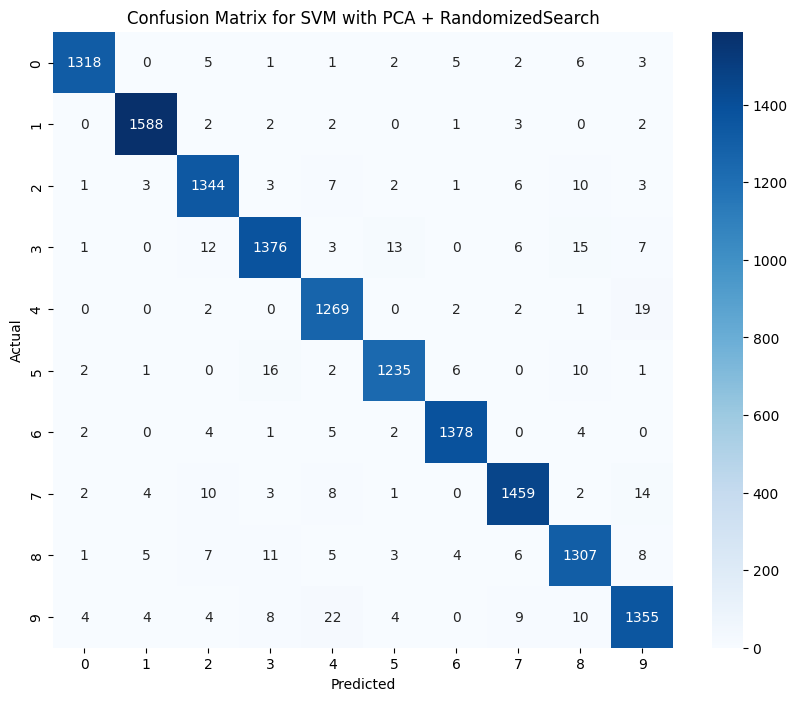

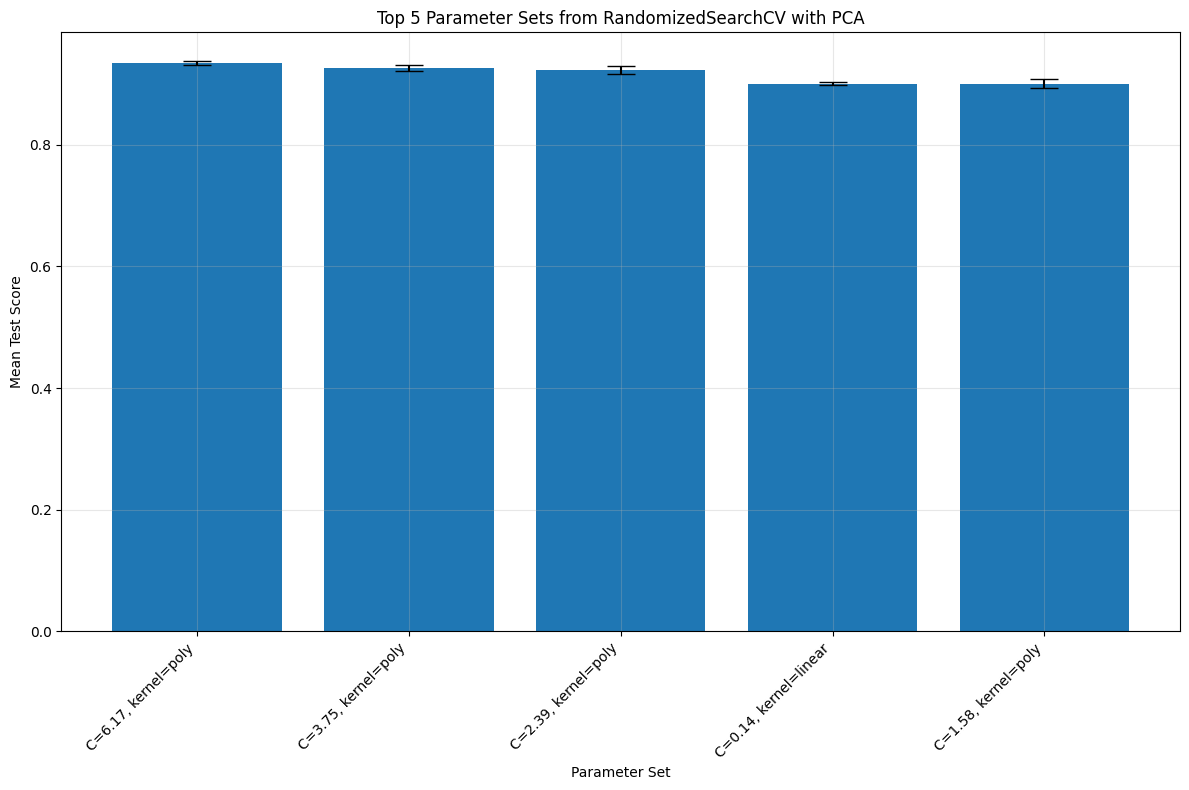

In [15]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Use PCA features
X_train_feature = X_train_pca
X_test_feature = X_test_pca
feature_name = "PCA"

# Convert to numpy arrays if needed
X_train_np = X_train_feature.to_numpy() if hasattr(X_train_feature, 'to_numpy') else np.array(X_train_feature)
X_test_np = X_test_feature.to_numpy() if hasattr(X_test_feature, 'to_numpy') else np.array(X_test_feature)
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

print(f"\nUsing {feature_name} features for SVM with RandomizedSearch")
print(f"Feature dimensions: {X_train_np.shape[1]}")

# Define parameter distributions for randomized search
param_distributions = {
    'C': loguniform(0.1, 100),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': loguniform(0.001, 1),
    'degree': [2, 3, 4]  # for poly kernel
}

# Take a subset for randomized search due to computational constraints
n_samples = 5000  # Adjust based on your computational resources
X_train_small = X_train_np[:n_samples]
y_train_small = y_train_np[:n_samples]

# Initialize SVM model
svm = SVC(random_state=42)

# Use RandomizedSearchCV to find good hyperparameters
print("Finding hyperparameters using Randomized Search...")
random_search = RandomizedSearchCV(
    svm, 
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Start time for training randomized search
start_time = time.time()
random_search.fit(X_train_small, y_train_small)
random_search_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best SVM model on the full dataset
best_svm = SVC(**best_params, random_state=42)

# Start time for training
print(f"Training SVM with {feature_name} features using best parameters...")
start_time = time.time()
best_svm.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = best_svm.predict(X_test_np)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
conf_matrix = confusion_matrix(y_test_np, y_pred)
classification_rep = classification_report(y_test_np, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(best_svm.support_vectors_)

# Print evaluation metrics
print(f"\nSVM Model with {feature_name} + RandomizedSearch Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Randomized Search Time: {random_search_time:.4f} seconds")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")
print(f"Best Parameters: {best_params}")

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for SVM with {feature_name} + RandomizedSearch")
plt.show()

# Visualize top results from randomized search
results = pd.DataFrame(random_search.cv_results_)
top_results = results.sort_values(by='rank_test_score').head(5)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_results)), top_results['mean_test_score'], 
        yerr=top_results['std_test_score'], capsize=10)
plt.xticks(range(len(top_results)), 
           [f"C={p['C']:.2f}, kernel={p['kernel']}" for p in top_results['params']], 
           rotation=45, ha='right')
plt.xlabel('Parameter Set')
plt.ylabel('Mean Test Score')
plt.title(f'Top 5 Parameter Sets from RandomizedSearchCV with {feature_name}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Selected Feature: HOG


Using HOG features for SVM with RandomizedSearch
Feature dimensions: 144
Finding hyperparameters using Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': np.float64(1.3292918943162166), 'degree': 2, 'gamma': np.float64(0.003550621427070771), 'kernel': 'linear'}
Training SVM with HOG features using best parameters...

SVM Model with HOG + RandomizedSearch Evaluation:
Accuracy: 94.67%
Precision: 94.67%
Recall: 94.67%
F1-score: 94.67%
Randomized Search Time: 23.5459 seconds
Training Time: 85.2555 seconds
Prediction Time: 18.2400 seconds
Model Complexity (Number of Support Vectors): 10246
Best Parameters: {'C': np.float64(1.3292918943162166), 'degree': 2, 'gamma': np.float64(0.003550621427070771), 'kernel': 'linear'}


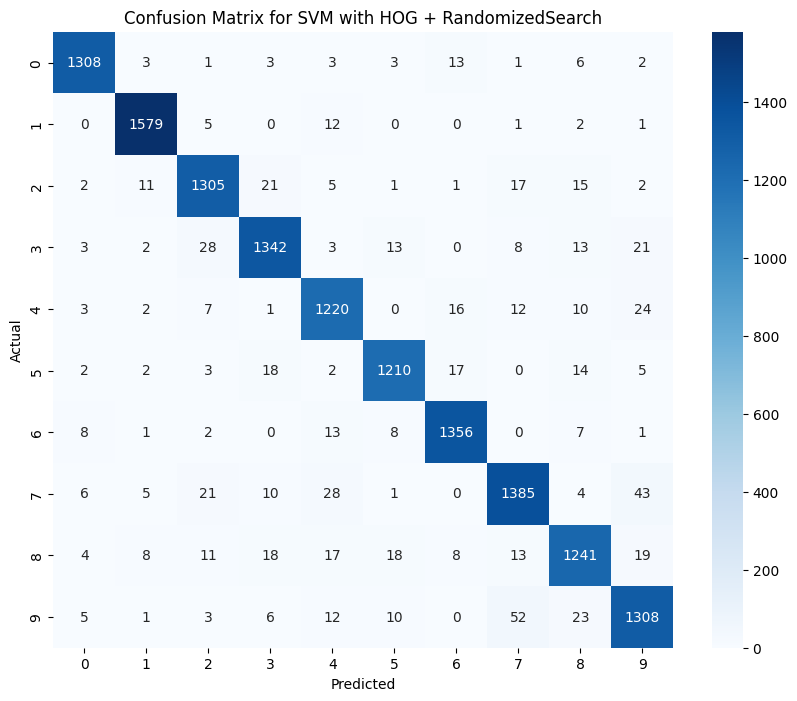

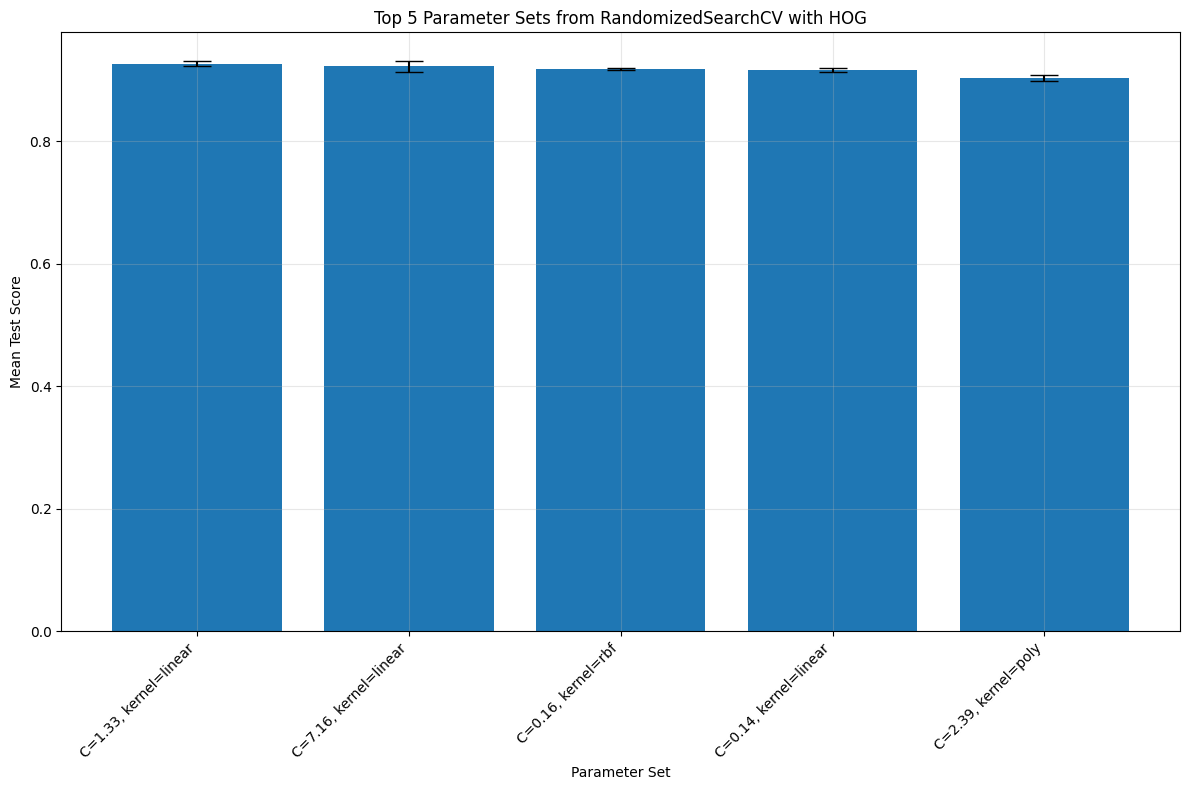

In [16]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Use HOG features
X_train_feature = X_train_hog
X_test_feature = X_test_hog
feature_name = "HOG"

# Convert to numpy arrays if needed
X_train_np = X_train_feature.to_numpy() if hasattr(X_train_feature, 'to_numpy') else np.array(X_train_feature)
X_test_np = X_test_feature.to_numpy() if hasattr(X_test_feature, 'to_numpy') else np.array(X_test_feature)
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

print(f"\nUsing {feature_name} features for SVM with RandomizedSearch")
print(f"Feature dimensions: {X_train_np.shape[1]}")

# Define parameter distributions for randomized search
param_distributions = {
    'C': loguniform(0.1, 100),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': loguniform(0.001, 1),
    'degree': [2, 3, 4]  # for poly kernel
}

# Take a subset for randomized search due to computational constraints
n_samples = 5000  # Adjust based on your computational resources
X_train_small = X_train_np[:n_samples]
y_train_small = y_train_np[:n_samples]

# Initialize SVM model
svm = SVC(random_state=42)

# Use RandomizedSearchCV to find good hyperparameters
print("Finding hyperparameters using Randomized Search...")
random_search = RandomizedSearchCV(
    svm, 
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Start time for training randomized search
start_time = time.time()
random_search.fit(X_train_small, y_train_small)
random_search_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best SVM model on the full dataset
best_svm = SVC(**best_params, random_state=42)

# Start time for training
print(f"Training SVM with {feature_name} features using best parameters...")
start_time = time.time()
best_svm.fit(X_train_np, y_train_np)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = best_svm.predict(X_test_np)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)
conf_matrix = confusion_matrix(y_test_np, y_pred)
classification_rep = classification_report(y_test_np, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors
model_complexity = len(best_svm.support_vectors_)

# Print evaluation metrics
print(f"\nSVM Model with {feature_name} + RandomizedSearch Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Randomized Search Time: {random_search_time:.4f} seconds")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")
print(f"Best Parameters: {best_params}")

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for SVM with {feature_name} + RandomizedSearch")
plt.show()

# Visualize top results from randomized search
results = pd.DataFrame(random_search.cv_results_)
top_results = results.sort_values(by='rank_test_score').head(5)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_results)), top_results['mean_test_score'], 
        yerr=top_results['std_test_score'], capsize=10)
plt.xticks(range(len(top_results)), 
           [f"C={p['C']:.2f}, kernel={p['kernel']}" for p in top_results['params']], 
           rotation=45, ha='right')
plt.xlabel('Parameter Set')
plt.ylabel('Mean Test Score')
plt.title(f'Top 5 Parameter Sets from RandomizedSearchCV with {feature_name}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Algorithm 2: Random Forest (Bernice Chng)

Algorithm 3: K-Nearest Neighbour (KNN) (Carine)

Selected Feature: Zoning

Best Parameters: {'n_neighbors': np.int64(11)}
Best Cross-Validation Accuracy: 84.20%
KNN Model Accuracy (Zoning Features with RandomizedSearch): 84.66%
Precision: 84.76%
Recall: 84.66%
F1-score: 84.65%
Training Time: 14.9982 seconds
Prediction Time: 0.6050 seconds
Model Complexity (Number of Neighbors): 11

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1343
           1       0.92      0.96      0.94      1600
           2       0.91      0.85      0.88      1380
           3       0.82      0.83      0.82      1433
           4       0.81      0.80      0.81      1295
           5       0.86      0.79      0.82      1273
           6       0.93      0.94      0.93      1396
           7       0.86      0.81      0.84      1503
           8       0.77      0.74      0.76      1357
           9       0.73      0.81      0.77      1420

    accuracy                           0.85     14000
   macro

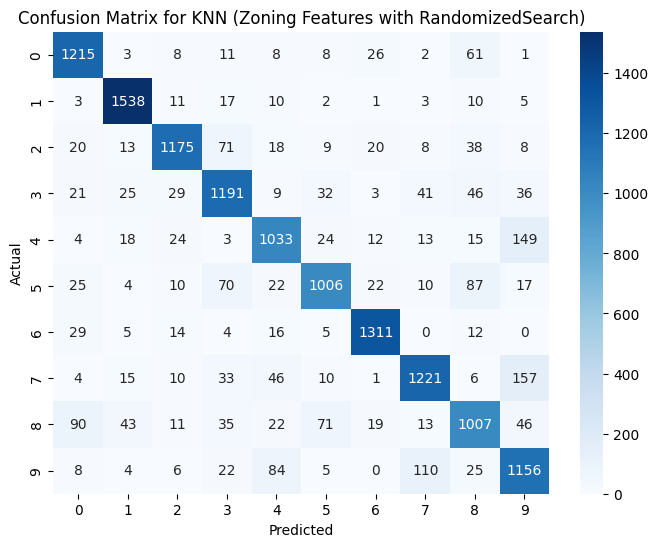

In [33]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {'n_neighbors': np.arange(1, 50, 2)}  # Testing odd values from 1 to 49

# Initialize KNN model
knn = KNeighborsClassifier()

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)

# Measure training time
start_time = time.time()
random_search.fit(X_train_zoning, y_train)
training_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score * 100:.2f}%")

# Train the best KNN model
best_knn = random_search.best_estimator_

# Measure prediction time
start_time = time.time()
y_pred = best_knn.predict(X_test_zoning)
prediction_time = time.time() - start_time

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score (weighted)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = best_params["n_neighbors"]

# Print evaluation metrics
print(f"KNN Model Accuracy (Zoning Features with RandomizedSearch): {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN (Zoning Features with RandomizedSearch)")
plt.show()

Selected Feature: HOG

Best Parameters: {'n_neighbors': np.int64(11)}
Best Cross-Validation Accuracy: 93.97%
KNN Model Accuracy (HOG Features with RandomizedSearch): 94.11%
Precision: 94.32%
Recall: 94.11%
F1-score: 94.14%
Training Time: 37.4486 seconds
Prediction Time: 1.4759 seconds
Model Complexity (Number of Neighbors): 11

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1343
           1       0.96      0.99      0.97      1600
           2       0.98      0.93      0.95      1380
           3       0.93      0.93      0.93      1433
           4       0.97      0.88      0.93      1295
           5       0.97      0.94      0.95      1273
           6       0.96      0.99      0.97      1396
           7       0.95      0.91      0.93      1503
           8       0.92      0.91      0.92      1357
           9       0.83      0.95      0.89      1420

    accuracy                           0.94     14000
   macro av

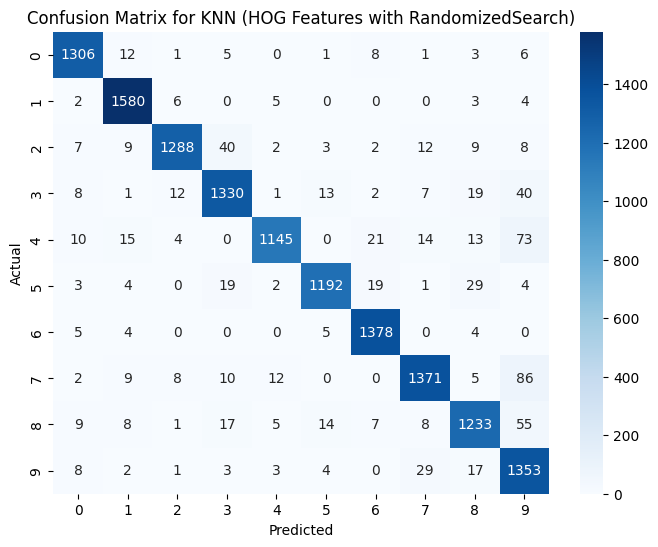

In [35]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {'n_neighbors': np.arange(1, 50, 2)}  # Testing odd values from 1 to 49

# Initialize KNN model
knn = KNeighborsClassifier()

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)

# Measure training time
start_time = time.time()
random_search.fit(X_train_hog, y_train)
training_time = time.time() - start_time

# Best hyperparameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score * 100:.2f}%")

# Train the best KNN model
best_knn = random_search.best_estimator_

# Measure prediction time
start_time = time.time()
y_pred = best_knn.predict(X_test_hog)
prediction_time = time.time() - start_time

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score (weighted)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = best_params["n_neighbors"]

# Print evaluation metrics
print(f"KNN Model Accuracy (HOG Features with RandomizedSearch): {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN (HOG Features with RandomizedSearch)")
plt.show()

Algorithm 4: Logistic Regression (Andrea)

Selected Feature: PCA

Finding best hyperparameters using RandomizedSearchCV for Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for Logistic Regression: {'C': np.float64(2.7609918202254335), 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 912, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': np.float64(0.00016636406741193932)}
Best Cross-Validation Accuracy: 90.27%

Random Forest Model Evaluation:
Accuracy: 90.67%
Precision: 90.65%
Recall: 90.67%
F1-score: 90.65%
Training Time: 4.3360 seconds
Prediction Time: 0.0020 seconds
Model Complexity (Regularization Strength - C):  1.0

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1343
           1       0.95      0.97      0.96      1600
           2       0.90      0.89      0.89      1380
           3       0.88      0.87      0.88      1433
           4       0.91      0.91      0.91      1295
           5       0

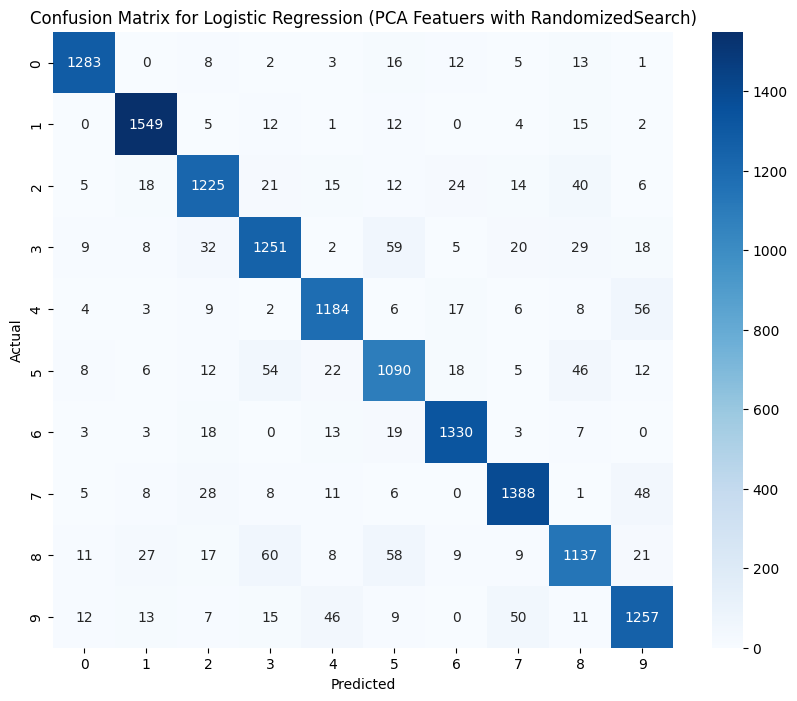

In [37]:
# Define the hyperparameter for Logstic Regression
param_grid_lr = {

    'penalty': ['l2'],  # Regularization types
    'tol': uniform(1e-5, 1e-2),   # Tolerance for optimization convergence
    'C': uniform(0.001, 10),  # Regularization strength (inverse of regularization)
    'fit_intercept': [True, False],  # Whether to include an intercept in the model
    'class_weight': ['balanced', None],  # Weighting classes to handle imbalanced data
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga' ],  # Optimization of algorithms that support multiclass
    'max_iter': randint(100, 1000),  # Maximum number of iterations for optimization

}

# Initialize Logistic Regression model
lr = LogisticRegression()

# Use RandomizedSearchCV for hyperparameter
print("Finding best hyperparameters using RandomizedSearchCV for Logistic Regression...")
random_search_lr = RandomizedSearchCV(
    lr, param_grid_lr, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start time for fiting
start_time = time.time()
random_search_lr.fit(X_train_pca, y_train)
fitting_time_lr = time.time() - start_time


# Best hyperparameters
best_params_lr = random_search_lr.best_params_
best_score_lr = random_search_lr.best_score_
print(f"Best Parameters for Logistic Regression: {best_params_lr}")
print(f"Best Cross-Validation Accuracy: {best_score_lr * 100:.2f}%")

# Train best Logistic Regression model
best_lr = LogisticRegression(
    **best_params_lr, random_state=42, n_jobs=-1
)


# Start time for training
start_time = time.time()
best_lr.fit(X_train_pca, y_train)
training_time_lr = time.time() - start_time


# Start time for prediction
start_time = time.time()
y_pred_lr = best_lr.predict(X_test_pca)
prediction_time_lr = time.time() - start_time

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_rep_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Extract precision, recall, and F1-score (weighted average)
precision_lr = classification_rep_lr["weighted avg"]["precision"]
recall_lr = classification_rep_lr["weighted avg"]["recall"]
f1_lr = classification_rep_lr["weighted avg"]["f1-score"]

# Model complexity - Regularization Strength(C) 
# Smaller C = simpler, larger C = complex.
model_complexity = lr.C

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Precision: {precision_lr * 100:.2f}%")
print(f"Recall: {recall_lr * 100:.2f}%")
print(f"F1-score: {f1_lr * 100:.2f}%")
print(f"Training Time: {training_time_lr:.4f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")
print(f"Model Complexity (Regularization Strength - C):  {model_complexity}")



# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))


# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression (PCA Featuers with RandomizedSearch)")
plt.show()

Algorithm 5: Decision Trees (Yin Er)

**COMPARISONS WITH ALGO**
- Accuracy
- Precision
- Recall
- F1-score
- Computation time
- Model complexity